# Sea Ice Indicators Update: MASIE regions

##### 2021-02-01

This report presents some new graphics summarizing our sea ice indicator results by MASIE region, relying on the most recent (2021-01-15) iteration of the indicators algortihm. 

The graphics below are violin plots of the indicator success rates and mean start/end dates calculated for each MASIE region, for each indicator type. These are distributions of the results taken across all years (1979-2018).

Violin plots are essentially smoothed histograms, showing a kernel density-smoothed distribution of the values. In this case, they are arranged in a boxplot-style layout that allows comparison of the distributions among the different levels of start/end date and MASIE region.

## Indicator success rates

These plots show the indicator "success" rates - the percentage of grid cells within the region for which the given indicator was defined. 

Note: we now have the requirement that both start/end be defined for *either* to be defined, for both indicator types (freezeup/breakup), so start/end success rates are equal for either indicator type.

In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import seaborn as sns
import xarray as xr
from pathlib import Path
from rasterstats import zonal_stats
from shapely.geometry import Polygon


def get_polygon(row):
    """Create shapely polygon object from row of 
    alternating lat/lon coords
    """
    df_di = {"lat": [], "lon": []}
    for idx, value in zip(row.index, row):
         
        if pd.isnull(value):
            df_di["lat"].append(df_di["lat"][0])
            df_di["lon"].append(df_di["lon"][0])
            break
        if "Lat" in idx:
            df_di["lat"].append(value)
        if "Lon" in idx:
            df_di["lon"].append(value)
            
    df = pd.DataFrame(df_di)
    
    return Polygon(list(zip(df.lon, df.lat)))


def make_plot_df(zs, stat, ind=None):
    """Make DataFrame for plotting"""
    # don't define ind for freezeup/breakup comparison
    if ind:
        variables = [ind + ind_type for ind_type in ["_start", "_end"]]
        group_names = ["Start", "End"]
    else:
        variables = ["freezeup_start", "breakup_start"]
        group_names = ["Freezeup", "Breakup"]
        
    fu_stats = pd.DataFrame({
        "region": np.tile(df["Name"].values, 2 * len(zs[variables[0]])),
        "indicator_type": np.repeat(group_names, len(zs[variables[0]]) * len(zs[variables[0]][0])),
        "value": [
            region_stats[stat] 
            for indicator in variables 
            for year_stats in zs[indicator] 
            for region_stats in year_stats]
    })

    return fu_stats.replace({"region": {
        "Baffin Bay/Gulf of St. Lawrence": "Baffin Bay", 
        "Canadian Archipelago": "Canadian Arch.", 
        "East Siberian Sea": "E. Siberian Sea",
    }})


def plot_violin(stats_df, title, palette, loc="upper left", ylab="Day of year"):
    """Make violin plot from Prepped data frame"""
    plt.figure(figsize=(18, 6))
    ax = sns.violinplot(
        x="region", 
        y="value", 
        hue="indicator_type",
        data=stats_df, 
        palette=palette, 
        split=True,
        inner="stick", 
    )
    
    # offset tick label placement to help display long region names
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)
    
    ax.xaxis.labelpad = 15
    plt.title(title, size=16)
    plt.xlabel("MASIE Region", size=16)
    plt.ylabel(ylab, size=16)
    plt.legend(loc=loc, prop={"size": 14})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()
    
    return None


base_dir = Path(os.getenv("BASE_DIR"))

masie_fp = base_dir.joinpath("ancillary/MASIE_regions_polygon_vertices.xls")

df = pd.read_excel(masie_fp, skiprows=1)

polys = df[["Region Number Identifier", "Name"]].copy()
for index, row in df.iterrows(): 
    polys.loc[index, "geometry"] = get_polygon(row)

polys = gpd.GeoDataFrame(polys).set_crs(epsg=4326).to_crs(epsg=3411)

fubu_fp = base_dir.joinpath("outputs/NetCDF/nsidc_0051_sic_nasateam_1979-2018_north_smoothed_fubu_dates.nc")

with rio.open(f"netcdf:{fubu_fp}:breakup_end") as src:
    affine = src.meta["transform"]

ds = xr.load_dataset(fubu_fp)

def rate(x):
    x = x.flatten()
    return round(x[~np.isnan(x)].shape[0] / x.shape[0], 3) * 100

# compute stats for all variables
zs = {}
for variable in list(ds.variables)[:4]:
    zs[variable] = [
        zonal_stats(
            polys, 
            arr, 
            affine=affine,
            nodata=np.nan, 
            stats=["mean"],
            add_stats={"rate": rate}
        ) 
        for arr in ds[variable].values
    ]

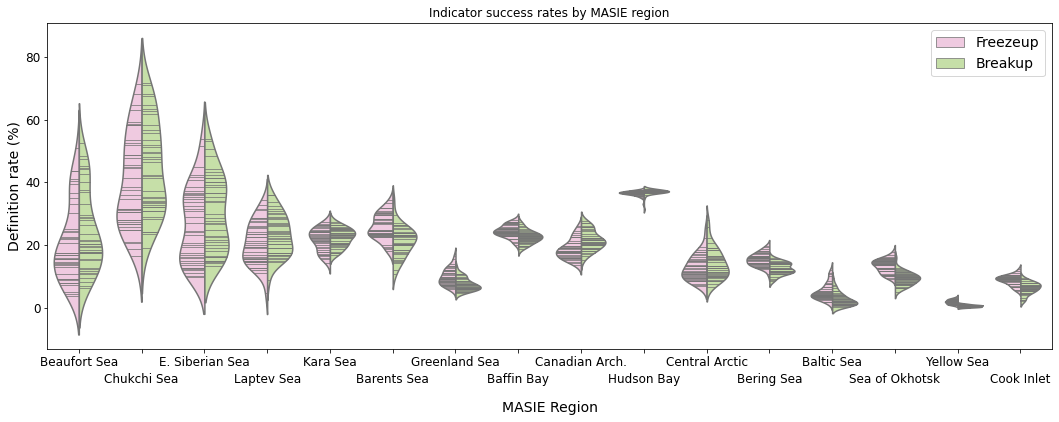

In [8]:
plot_violin(
    make_plot_df(zs, "rate"), 
    "Indicator success rates by MASIE region", 
    "PiYG", 
    "upper right", 
    "Definition rate (%)"
)

## Mean day of year

These plots show the distributions of the region-wise mean day-of-year for each indicator. 

### Freeze-up

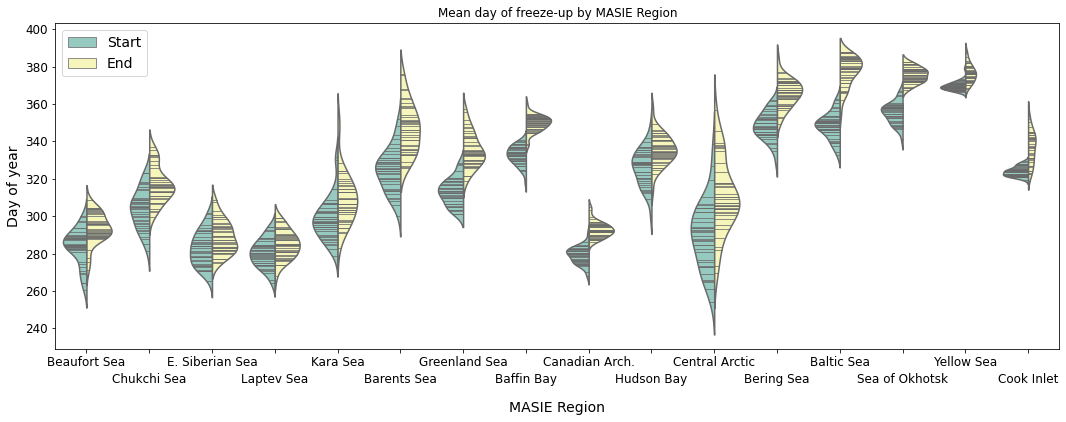

In [9]:
plot_violin(make_plot_df(zs, "mean", "freezeup"), "Mean day of freeze-up by MASIE Region", "Set3")

### Break-up

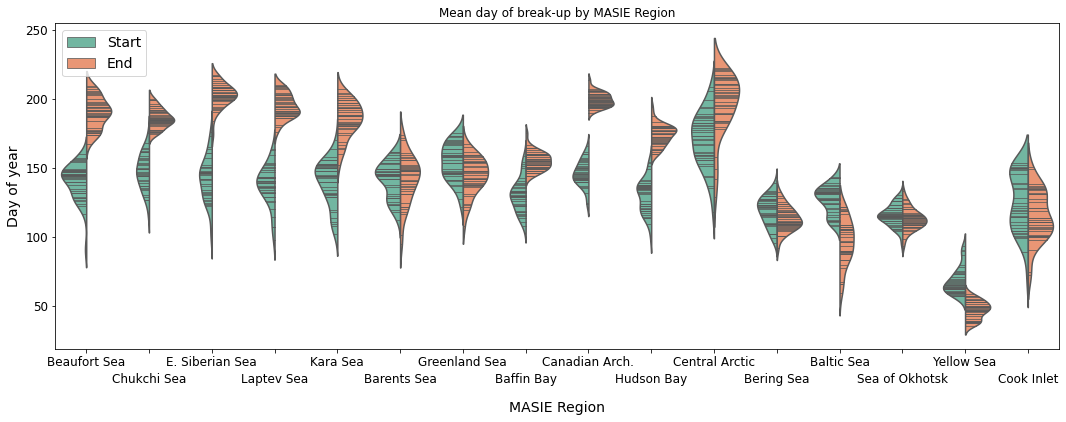

In [11]:
plot_violin(make_plot_df(zs, "mean", "breakup"), "Mean day of break-up by MASIE Region", "Set2")